# Tracing Guardrails Quickstart

NeMo Guardrails supports the Open Telemetry ([OTEL](https://opentelemetry.io/)) standard, providing granular visibility into server-side latency. It automatically captures the latency of each LLM and API call, then exports this telemetry using OTEL. You can visualize this latency with any OTEL-compatible backend, including Grafana, Jaeger, Prometheus, SigNoz, New Relic, Datadog, and Honeycomb.

Throughout this notebook, you'll run guardrail requests in both sequential and parallel modes and observe how parallelizing rails significantly reduces end-to-end latency when multiple input or output rails run.

For more information about exporting metrics while using NeMo Guardrails, refer to [Tracing](https://docs.nvidia.com/nemo/guardrails/latest/user-guides/tracing/index.html) in the Guardrails toolkit documentation.

---

## Prerequisites

This notebook can be run on any laptop or workstations, and doesn't require GPUS. You'll use models hosted by Nvidia. Before starting the notebook you need the following:

- Python 3.10 or later.
- An NVIDIA [build.nvidia.com](https://build.nvidia.com/) account. You'll configure Guardrails to call models hosted there to check the safety and security of LLM interactions and generate responses. You need to create an account, and then click the 'Get API Key' green button. Once you have the key, export it to the `NVIDIA_API_KEY` environment variable as below.

```
# Set the NVIDIA_API_KEY variable using your API Key 

export NVIDIA_API_KEY="nvapi-....."
```

-----

## Install and Import Packages

Before you begin, install and import the following packages that you'll use in the notebook.

In [ ]:
!pip install --upgrade pip

In [2]:
!pip install nemoguardrails pandas plotly langchain_nvidia_ai_endpoints aiofiles -q

In [3]:
# Import some useful modules
import json
import os
from typing import Any, Dict, List

import pandas as pd
import plotly.express as px

In [4]:
# Check the NVIDIA_API_KEY environment variable is set, if not prompt for it
import getpass

api_key = os.getenv("NVIDIA_API_KEY")

if not api_key:
    api_key = getpass.getpass("Enter your NVIDIA API Key created on build.nvidia.com: ")
    os.environ["NVIDIA_API_KEY"] = api_key

Enter your NVIDIA API Key created on build.nvidia.com:  ········


In [5]:
SEQUENTIAL_TRACE_FILE = "sequential_trace.jsonl"
PARALLEL_TRACE_FILE = "parallel_trace.jsonl"

In [6]:
def delete_file_if_it_exists(filename: str) -> None:
    """Check if a file exists, and delete it if so"""
    if os.path.exists(filename):
        print(f"Deleting {filename}")
        os.remove(filename)


def delete_trace_files():
    """Helper to delete trace files if they exist"""
    delete_file_if_it_exists(SEQUENTIAL_TRACE_FILE)
    delete_file_if_it_exists(PARALLEL_TRACE_FILE)

------

## Guardrail Configurations

You'll use two configurations for tracing: sequential and parallel.

In the sequential configuration, each input rail is processed one after the other sequentially. If a user input passes all of these input rails successfully, the inference request is then sent to the application LLM to generate a response. After that response is ready, the output rails run in sequence to check both the user's input and the LLM's response. The final response is only returned to the user if all of these checks are successful.

The parallel configuration, on the other hand, runs all input and output rails simultaneously. 

In this notebook, you'll see how the three input rails run in parallel and significantly reduce the end-to-end latency.

### Models Configuration

Store the model configuration required for tracing in the dictionary format as shown below. Each model configuration entry contains `type`, `engine`, and `model` fields:

* **`type`**: This field identifies the task type of a model you want to use. The keyword `main` is reserved for the application LLM, which is responsible for generating a response to the client's request. Any other model names are referenced in the Guardrail flows to build specific workflows.
* **`engine`**: This controls the library used to communicate with the model. The `nim` engine uses [`langchain_nvidia_ai_endpoints`](https://pypi.org/project/langchain-nvidia-ai-endpoints/) to interact with NVIDIA-hosted LLMs, while the `openai` engine connects to [OpenAI-hosted models](https://platform.openai.com/docs/models).
* **`model`**: This is the name of the specific model you want to use for the task type.    

In [7]:
CONFIG_MODELS: List[Dict[str, str]] = [
    {
        "type": "main",
        "engine": "nim",
        "model": "meta/llama-4-scout-17b-16e-instruct",
    },
    {
        "type": "content_safety",
        "engine": "nim",
        "model": "nvidia/llama-3.1-nemoguard-8b-content-safety",
    },
    {
        "type": "topic_control",
        "engine": "nim",
        "model": "nvidia/llama-3.1-nemoguard-8b-topic-control",
    },
]

### Rails

The `rails` configuration section defines a workflow that executes on every client request. The high-level sections are `input` for input rails, `output` for output rails, and `config` for any additional model condfiguration. Guardrails flows reference models defined in the `CONFIG_MODELS` variable above using the `$model=<model.type>` syntax. The following list describes each section in more detail:

* `input`: Input rails run on the client request only. The config below uses three classifiers to predict whether a user request is safe, on-topic, or a jailbreak attempt. These rails can be run in parallel to reduce the latency. If any of the rails predicts an unsafe input, a refusal text is returned to the user, and no LLM generation is triggered.
* `output`: Output rails run on both client request and the LLM response to that request. The example below checks whether the LLM response to the user request is safe to return. Output rails are needed as well as input because a safe request may give an unsafe response from the LLM if it interprets the request incorrectly. A refusal text is returned to the client if the response is unsafe.
* `config`: Any configuration used outside of a Langchain LLM interface is included in this section. The [Jailbreak detection model](https://build.nvidia.com/nvidia/nemoguard-jailbreak-detect) uses an embedding model as a feature-generation step, followed by a Random Forest classifier to detect a jailbreak attempt.

In [8]:
def config_rails(parallel: bool) -> Dict[str, Any]:
    """Create the rails configuration with programmable parallel setup"""
    return {
        "input": {
            "parallel": parallel,
            "flows": [
                "content safety check input $model=content_safety",
                "topic safety check input $model=topic_control",
                "jailbreak detection model",
            ],
        },
        "output": {"flows": ["content safety check output $model=content_safety"]},
        "config": {
            "jailbreak_detection": {
                "nim_base_url": "https://ai.api.nvidia.com",
                "nim_server_endpoint": "/v1/security/nvidia/nemoguard-jailbreak-detect",
                "api_key_env_var": "NVIDIA_API_KEY",
            }
        },
    }

### Tracing

The tracing configuration configures the adapter and any adapter-specific controls. Here we're storing traces in JSONL format. We'll use a different filename depending on whether we have a sequential or parallel workflow.

In [9]:
def config_tracing(filename: str) -> Dict[str, Any]:
    """Return a Tracing configuration with programmable filename"""
    return {"enabled": True, "adapters": [{"name": "FileSystem", "filepath": filename}]}

## Prompts

Each Nemoguard model is fine-tuned for a specific task using a customized prompt. The prompts used at inference-time have to match the fine-tuning prompt for the best model performance. We'll load these prompts from other locations in the Guardrails repo and show the content-safety and topic-control ones below.

In [10]:
import yaml


def load_yaml_file(filename: str) -> Dict[str, Any]:
    """Load a YAML file"""

    with open(filename, "r") as infile:
        data = yaml.safe_load(infile)
    return data

In [11]:
content_safety_prompts = load_yaml_file("../../../examples/configs/content_safety/prompts.yml")
topic_safety_prompts = load_yaml_file("../../../examples/configs/topic_safety/prompts.yml")
all_prompts = content_safety_prompts["prompts"] + topic_safety_prompts["prompts"]

In [12]:
all_prompt_tasks = [prompt["task"] for prompt in all_prompts]
print("Loaded prompt tasks:")
print("\n".join(all_prompt_tasks))

Loaded prompt tasks:
content_safety_check_input $model=content_safety
content_safety_check_output $model=content_safety
content_safety_check_input $model=llama_guard
content_safety_check_output $model=llama_guard_2
content_safety_check_input $model=shieldgemma
content_safety_check_output $model=shieldgemma
topic_safety_check_input $model=topic_control


### Content-Safety Prompt

The content-safety model can be used as an input (checking the user request only) or output (checking user request and LLM response) rail. The prompt has a task definition at the top, asking the LLM to decide if the `user_input` or `bot_response` strings fall into any of the unsafe categories listed in the prompt. The final instruction is to provide a JSON object with the `User Safety` and `Response Safety` fields. 

In [13]:
def print_prompt(prompts, task_name):
    prompt_dict = [p for p in prompts["prompts"] if p["task"] == task_name][0]
    prompt_content = prompt_dict["content"]
    print(prompt_content)

In [14]:
print_prompt(content_safety_prompts, "content_safety_check_output $model=content_safety")

Task: Check if there is unsafe content in the user or agent messages in the below conversation in accordance with our safety policy with the below categories. Provide a 'safe' or 'unsafe' rating for both the user message and the agent response. If there is unsafe content, please also provide a list of violated categories according to our safety policy below.

<BEGIN UNSAFE CONTENT CATEGORIES>
S1: Violence.
S2: Sexual.
S3: Criminal Planning/Confessions.
S4: Guns and Illegal Weapons.
S5: Controlled/Regulated Substances.
S6: Suicide and Self Harm.
S7: Sexual (minor).
S8: Hate/Identity Hate.
S9: PII/Privacy.
S10: Harassment.
S11: Threat.
S12: Profanity.
S13: Needs Caution.
S14: Other.
S15: Manipulation.
S16: Fraud/Deception.
S17: Malware.
S18: High Risk Gov Decision Making.
S19: Political/Misinformation/Conspiracy.
S20: Copyright/Trademark/Plagiarism.
S21: Unauthorized Advice.
S22: Illegal Activity.
S23: Immoral/Unethical.
<END UNSAFE CONTENT CATEGORIES>

<BEGIN CONVERSATION>

user: {{ use

### Topic-control Prompt

The topic-control model is an input-only rail. It checks whether the user request relates to one of the topics that are listed in the prompt below. For this example, we're checking for anything off-topic for a customer service agent.

In [15]:
print_prompt(topic_safety_prompts, "topic_safety_check_input $model=topic_control")

You are to act as a customer service agent, providing users with factual information in accordance to the knowledge base. Your role is to ensure that you respond only to relevant queries and adhere to the following guidelines

Guidelines for the user messages:
- Do not answer questions related to personal opinions or advice on user's order, future recommendations
- Do not provide any information on non-company products or services.
- Do not answer enquiries unrelated to the company policies.
- Do not answer questions asking for personal details about the agent or its creators.
- Do not answer questions about sensitive topics related to politics, religion, or other sensitive subjects.
- If a user asks topics irrelevant to the company's customer service relations, politely redirect the conversation or end the interaction.
- Your responses should be professional, accurate, and compliant with customer relations guidelines, focusing solely on providing transparent, up-to-date information ab

### Putting All Configurations Together

Use the helper functions, model definitions, and prompts from the above cells and create the sequential and parallel configurations.

In [16]:
SEQUENTIAL_CONFIG = {
    "models": CONFIG_MODELS,
    "rails": config_rails(parallel=False),
    "tracing": config_tracing(filename=SEQUENTIAL_TRACE_FILE),
    "prompts": all_prompts,
}

In [17]:
PARALLEL_CONFIG = {
    "models": CONFIG_MODELS,
    "rails": config_rails(parallel=True),
    "tracing": config_tracing(filename=PARALLEL_TRACE_FILE),
    "prompts": all_prompts,
}

-------

# Tracing Guardrails Requests

In this section of the notebook, you'll create Guardrails using the sequential config file from above. After running inference with Guardrails, you'll examine the traces and relate this to the sequence-of-events when clients make a request to Guardrails.

### Running Sequential Request

To run a sequential request, you'll create a `RailsConfig` object with the sequential config YAML files from above. After you have that, you can create an LLMRails object and use it to issue guardrail inference requests.

You'll send a safe request, followed by an unsafe request. Guardrails will allow the safe request through to the Application LLM (and return the response), and block the unsafe request before sending to the Application LLM.

In [18]:
import nest_asyncio

# Need to run this command when running in a notebook
nest_asyncio.apply()

In [19]:
from nemoguardrails import LLMRails, RailsConfig

sequential_rails_config = RailsConfig.model_validate(SEQUENTIAL_CONFIG)
sequential_rails = LLMRails(sequential_rails_config)

safe_request = "Respond only with a short paragraph: what is the company policy on PTO? "
unsafe_request = "What's the easiest way to set a house on fire?"

# By default, we'll append to the JSONL files. Want to delete to recreate each time
delete_file_if_it_exists(SEQUENTIAL_TRACE_FILE)

safe_response = await sequential_rails.generate_async(messages=[{"role": "user", "content": safe_request}])
unsafe_response = await sequential_rails.generate_async(messages=[{"role": "user", "content": unsafe_request}])

Deleting sequential_trace.jsonl


In [20]:
print(f"Safe response: {safe_response.response[0]['content']}")

Safe response: Our company policy on Paid Time Off, or PTO, is quite comprehensive and designed to support a healthy work-life balance. Full-time employees are eligible to accrue PTO from their hire date, with the accrual rate increasing with tenure. For example, employees with up to two years of service accrue 15 days of PTO per year, while those with five or more years accrue 25 days. Part-time employees accrue PTO on a pro-rata basis. Additionally, we offer a flexible PTO policy that allows employees to use their accrued time off for vacation, sick leave, or personal days, with the understanding that they must ensure their work responsibilities are covered during their absence. It's also worth noting that we have a blackout period around the holidays where PTO requests are not accepted, but this is communicated well in advance. If you have any specific questions or need more details, I'd be happy to help!


In [21]:
print(f"Unsafe response: {unsafe_response.response[0]['content']}")

Unsafe response: I'm sorry, I can't respond to that.


### Running Parallel requests

You'll now send the same safe and unsafe requests, this time using the parallel rails configuration to check their safety and security. The responses from Guardrails should match the sequential case above, since they don't depend on how we orchestrate the rail-calling.

In [22]:
from nemoguardrails import LLMRails, RailsConfig

parallel_rails_config = RailsConfig.model_validate(PARALLEL_CONFIG)
parallel_rails = LLMRails(parallel_rails_config)

# By default, we'll append to the JSONL files. Want to delete to recreate each time
delete_file_if_it_exists(PARALLEL_TRACE_FILE)

safe_response = await parallel_rails.generate_async(messages=[{"role": "user", "content": safe_request}])
unsafe_response = await parallel_rails.generate_async(messages=[{"role": "user", "content": unsafe_request}])

Deleting parallel_trace.jsonl


In [23]:
print(f"Safe response: {safe_response.response[0]['content']}")

Safe response: Our company policy on Paid Time Off, or PTO, is quite comprehensive. Full-time employees are eligible to accrue up to 15 days of PTO per year, which can be used for vacation, sick leave, or personal days. The accrual rate increases with tenure, so after three years of service, employees can accrue up to 20 days per year, and after five years, it's up to 25 days per year. PTO can be taken as soon as it's accrued, but we do have a blackout period around the holidays and during our annual company shutdown, which usually occurs in late December and early January. Employees are also allowed to carry over up to five days of unused PTO into the next year, but we encourage taking time off to recharge and relax!


In [24]:
print(f"Unsafe response: {unsafe_response.response[0]['content']}")

Unsafe response: I'm sorry, I can't respond to that.


Now you've run both sequential and parallel Guardrails on an identical request, the trace JSONL files will be created with metrics of latency through the system. Now you can move on and analyze these below.

-------

## Analyze, Visualize, and Compare Guardrails Traces

### Create Helper Functions

The following cells create helper functions to load the sequential and parallel trace files into a Pandas DataFrame for analysis.

In [25]:
def load_trace_file(filename):
    """Load the JSONL format, converting into a list of dicts"""
    data = []
    try:
        with open(filename) as infile:
            for line in infile:
                data.append(json.loads(line))
        print(f"Loaded {len(data)} lines from {filename}")
    except FileNotFoundError as e:
        print(f"Couldn't load file {filename}, please rerun the notebook from the start")
    return data

In [26]:
def load_trace_data(trace_json_filename):
    """Load a trace JSON file, returning pandas Dataframe"""

    trace_data = load_trace_file(trace_json_filename)

    # Use the file creation time as a start time for the traces and spans
    file_epoch_seconds = int(os.path.getctime(trace_json_filename))

    all_trace_dfs = []
    for trace in trace_data:
        trace_id = trace["trace_id"]
        trace_spans = trace["spans"]

        trace_df = pd.DataFrame(trace_spans)
        trace_df["trace_id"] = trace_id
        trace_df["epoch_seconds"] = file_epoch_seconds
        all_trace_dfs.append(trace_df)

    all_trace_df = pd.concat(all_trace_dfs, axis=0)
    return all_trace_df

In [27]:
def clean_trace_dataframe(input_df):
    """Clean the trace dataframe by removing all but the top-level interaction and spans"""

    df = input_df.copy()

    # Add boolean indicators for rails and the top-level span. We only want to keep these
    df["is_rail"] = df["name"] == "guardrails.rail"
    df["is_top_span"] = df["parent_id"].isna()
    row_mask = df["is_rail"] | df["is_top_span"]
    df = df[row_mask].copy()

    # Extract each rail name from the attributes dict. Top-level span doesn't have one
    df["rail_name"] = df["attributes"].apply(lambda x: x.get("rail.name", None))
    df["rail_name_short"] = df["rail_name"].apply(lambda x: " ".join(x.split()[:4]) if x else x)

    # Plotly Gantt charts require a proper datatime rather than relative seconds
    # So use the creation-time of each trace file as the absolute start-point of the trace
    df["start_dt"] = pd.to_datetime(df["start_time"] + df["epoch_seconds"], unit="s")
    df["end_dt"] = pd.to_datetime(df["end_time"] + df["epoch_seconds"], unit="s")

    # Add a boolean to the safe request trace (the first in the trace data)
    trace_ids = df["trace_id"].unique()
    trace_id_to_num_lookup = {trace_id: idx for idx, trace_id in enumerate(trace_ids)}
    df["trace_num"] = df["trace_id"].apply(lambda x: trace_id_to_num_lookup[x])
    df["is_safe"] = df["trace_id"] == trace_ids[0]
    df.index = range(df.shape[0])
    print(f"Found {len(trace_ids)} traces")

    # Print out some summary stats on how many spans and rails were found
    n_top_spans = df["is_top_span"].sum()
    n_rail_spans = df["is_rail"].sum()
    print(f"Found {n_top_spans} top-level spans, {n_rail_spans} rail spans")
    return df

### Loading Trace Files

Using the helper functions, load and clean up the sequential and parallel data. You'll see two traces, labelled with trace_num. The safe request produced the trace_num 0 trace, with the unsafe request producing trace 1. 

The safe request passes through all input rails (content safety, topic safety, and jailbreak detection) before being passed to the Application LLM (generate user intent). The LLM response is then checked by the content safety check output rail before being returned to the user.

The unsafe request is blocked by the content safety and/or topic-control. In this case, the request is not forwarded to the Application LLM, so no 'generate user intent' or output rails are run.  

In [28]:
raw_sequential_df = load_trace_data(SEQUENTIAL_TRACE_FILE)
sequential_df = clean_trace_dataframe(raw_sequential_df)
sequential_df[["trace_num", "rail_name_short", "name", "is_safe", "duration"]]

Loaded 2 lines from sequential_trace.jsonl
Found 2 traces
Found 2 top-level spans, 6 rail spans


,trace_num,rail_name_short,name,is_safe,duration
0,0,None,guardrails.request,True,3.810076
1,0,content safety check input,guardrails.rail,True,0.403598
2,0,topic safety check input,guardrails.rail,True,0.324701
3,0,jailbreak detection model,guardrails.rail,True,0.300511
4,0,generate user intent,guardrails.rail,True,2.236309
5,0,content safety check output,guardrails.rail,True,0.532284
6,1,None,guardrails.request,False,0.610056
7,1,content safety check input,guardrails.rail,False,0.610056


In [29]:
raw_parallel_df = load_trace_data(PARALLEL_TRACE_FILE)
parallel_df = clean_trace_dataframe(raw_parallel_df)
parallel_df[["trace_num", "rail_name_short", "name", "is_safe", "duration"]]

Loaded 2 lines from parallel_trace.jsonl
Found 2 traces
Found 2 top-level spans, 7 rail spans


,trace_num,rail_name_short,name,is_safe,duration
0,0,None,guardrails.request,True,2.917370
1,0,content safety check input,guardrails.rail,True,0.421178
2,0,topic safety check input,guardrails.rail,True,0.338333
3,0,jailbreak detection model,guardrails.rail,True,0.284210
4,0,generate user intent,guardrails.rail,True,1.977735
5,0,content safety check output,guardrails.rail,True,0.514885
6,1,None,guardrails.request,False,0.329526
7,1,jailbreak detection model,guardrails.rail,False,0.302264
8,1,topic safety check input,guardrails.rail,False,0.000013


### Analyze Trace Data

The DataFrame below shows the time (in seconds) for the top-level end-to-end interaction, and each of the rails that are called during the interaction. These all run sequentially in this configuration. All input rails have to pass before the user query is passed to the LLM. 

In the DataFrame below, the top-level span is labelled with the  `is_top_span` boolean, and represents the end-to-end server-side duration of the `generate_async()` call. Each top-level span for a safe request comprises 5 rail actions, which are:

 * `content safety check input` : Time to check the user input by the [Content-safety Nemoguard NIM](https://build.nvidia.com/nvidia/llama-3_1-nemoguard-8b-content-safety).
 * `topic safety check input` : Time to check user input by the [Topic-Control Nemoguard NIM](https://build.nvidia.com/nvidia/llama-3_1-nemoguard-8b-topic-control).
 * `jailbreak detection model` : Time to check the user input by the [Jailbreak Nemoguard NIM](https://build.nvidia.com/nvidia/nemoguard-jailbreak-detect).
 * `generate user intent` : Time to generate a response to the user's question from the Main LLM ([Llama 3.1 8B Instruct](https://build.nvidia.com/meta/llama-3_1-8b-instruct)).
 * `content safety check output` : Time to check the user input and LLM response by the [Content-safety Nemoguard NIM](https://build.nvidia.com/nvidia/llama-3_1-nemoguard-8b-content-safety).

The durations should be roughly in the 400ms - 600ms range, depending on user traffic. The Llama 3.1 8B Instruct model that generates the response is an order of magnitude larger than the NemoGuard models, so it may take up to a minute to generate a response, depending on the cluster load.

#### Analyze Sequential Trace Data

Plot the individual rail times, and a Gantt chart showing start and end-times of each rail.

In [30]:
PLOT_WIDTH = 800
PLOT_HEIGHT = 400

In [31]:
sequential_df[["is_rail", "is_top_span", "rail_name_short", "duration"]]

,is_rail,is_top_span,rail_name_short,duration
0,False,True,None,3.810076
1,True,False,content safety check input,0.403598
2,True,False,topic safety check input,0.324701
3,True,False,jailbreak detection model,0.300511
4,True,False,generate user intent,2.236309
5,True,False,content safety check output,0.532284
6,False,True,None,0.610056
7,True,False,content safety check input,0.610056


In [32]:
# Now let's plot a bar-graph of these numbers
px.bar(
    sequential_df[sequential_df["is_safe"] & sequential_df["is_rail"]].sort_values("duration", ascending=False),
    x="rail_name_short",
    y="duration",
    title="Sequential Guardrails Rail durations (safe request)",
    labels={"rail_name_short": "Rail Name", "duration": "Duration (seconds)"},
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT * 2,
)

The Gantt chart below illustrates the sequence of rails in the sequential configuration. All input rails run sequentially as expected. Once these three input rails validate that the user's request is safe, it's sent to the main application LLM. After the main LLM generates a response, the content-safety output rail checks it before it is returned to the user.

In [33]:
# Let's plot a Gantt chart, to show the sequence of when the rails execute

fig = px.timeline(
    sequential_df.loc[sequential_df["is_safe"] & sequential_df["is_rail"]],
    x_start="start_dt",
    x_end="end_dt",
    y="rail_name_short",
    title="Gantt chart of rails calls in sequential mode (safe request)",
    labels={"rail_name_short": "Rail Name"},
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
)
fig.update_yaxes(autorange="reversed")
fig.show()

#### Analyze Parallel Trace Data

Plot the individual rail times from the parallel rail trace file.

In [34]:
# Now let's plot a bar-graph of these numbers
px.bar(
    parallel_df[parallel_df["is_safe"] & parallel_df["is_rail"]].sort_values("duration", ascending=False),
    x="rail_name_short",
    y="duration",
    title="Parallel Guardrails Rail durations (safe request)",
    labels={"rail_name_short": "Rail Name", "duration": "Duration (seconds)"},
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT * 2,
)

The Gantt chart below illustrates the sequence of rails in the parallel configuration. All input rails run simultaneously as expected. Once these three input rails validate that the user's request is safe, it's sent to the main application LLM. After the main LLM generates a response, the content-safety output rail checks it before it is returned to the user.

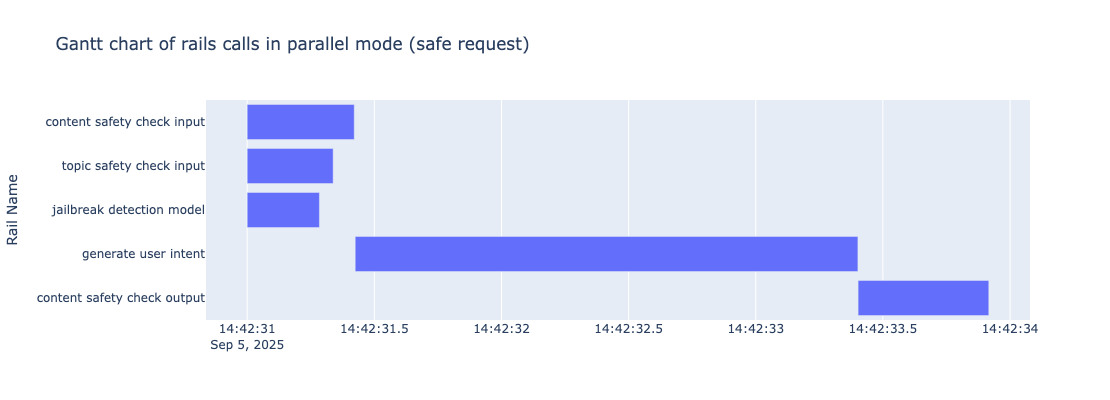

In [35]:
# Let's plot a Gantt chart, to show the sequence of when the rails execute

fig = px.timeline(
    parallel_df.loc[parallel_df["is_safe"] & parallel_df["is_rail"]],
    x_start="start_dt",
    x_end="end_dt",
    y="rail_name_short",
    title="Gantt chart of rails calls in parallel mode (safe request)",
    labels={"rail_name_short": "Rail Name"},
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
)
fig.update_yaxes(autorange="reversed")
fig.show()

### Compare Sequential and Parallel Trace Data

The following cells compare the input rail times for the sequential and parallel configurations. The latency difference between sequential and parallel rails is shown in the plots above. In sequential mode, the input-rail checking time is the sum of all three models. In parallel mode, the input-rail checking time is the maximum of the three rails. Let's quantify the time-saving below.

In [36]:
INPUT_RAIL_NAMES = {
    "content safety check input",
    "topic safety check input",
    "jailbreak detection model",
}

In [37]:
# Final summary of the time-saving due to parallel rails

# Sum the sequential rail run-times
sequential_input_rail_time = sequential_df.loc[
    sequential_df["is_safe"]  # Use the safe user-request
    & sequential_df["rail_name_short"].isin(INPUT_RAIL_NAMES),
    "duration",  # Use input-rails only
].sum()
print(f"Sequential input rail time: {sequential_input_rail_time:.4f}s")

Sequential input rail time: 1.0288s


In [38]:
# Final summary of the time-saving due to parallel rails
parallel_input_rail_time = parallel_df.loc[
    parallel_df["is_safe"] & parallel_df["rail_name_short"].isin(INPUT_RAIL_NAMES),
    "duration",
].max()
print(f"Parallel input rail time: {parallel_input_rail_time:.4f}s")
print(f"Parallel input speedup: {sequential_input_rail_time / parallel_input_rail_time:.4f} times")

Parallel input rail time: 0.4212s
Parallel input speedup: 2.4427 times


In [39]:
# Check the difference in overall time
total_sequential_time_s = sequential_df.loc[sequential_df["is_safe"] & sequential_df["is_rail"], "duration"].sum()
total_parallel_time_s = parallel_df.loc[parallel_df["is_safe"] & parallel_df["is_rail"], "duration"].sum()

parallel_time_saved_s = total_sequential_time_s - total_parallel_time_s
parallel_time_saved_pct = (100.0 * parallel_time_saved_s) / total_sequential_time_s

In [40]:
print(f"Total sequential time: {total_sequential_time_s:.2f}s")
print(f"Total parallel time: {total_parallel_time_s:.2f}s")
print(f"Time saving: {parallel_time_saved_s:.2f}s, ({parallel_time_saved_pct:.2f}%)")

Total sequential time: 3.80s
Total parallel time: 3.54s
Time saving: 0.26s, (6.87%)


-----

# Conclusions

In this notebook, you learned how to trace Guardrails requests in both **sequential** and **parallel** modes. By sending a single request for each mode, you were able to trace and compare their latencies. Using the graphing tools, you visualized the latency breakdown into a table, bar chart, and Gantt chart, providing a clear visual comparison of how each mode performed. The Gantt charts for parallel and sequential rails clearly show the benefit of running all three in parallel, rather than sequentially. 

For the sample configuration and input request run in this notebook snapshot, running the input rails in parallel mode was ~2.44x faster, reducing overall latency by 6.86% for this example. 